# Setup

In [1]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import sys

# Load data

In [2]:
comparison_folder = os.path.join(os.getcwd(),'data', 'BF_approximation_comparison')
bridge_file = '2021_06_29___15_12_BF_approx_comp'
NN_fixed_file = '2021_07_01___12_35_BF_NN_comp'
NN_variable_file = '2021_07_01___15_24_BF_NN_variable_comp'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
NN_variable = pd.read_csv(os.path.join(comparison_folder, NN_variable_file))

In [3]:
bridge.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,m0_bridge_error,m1_bridge_error,compile_time,stan_time,bridge_time
0,1,0,8.388963e-01,0.161104,0,1.920424e-01,0%,0%,39.907145,52.258780,35.962266
1,2,1,2.226466e-27,1.000000,1,4.491424e+26,0%,0%,39.907145,48.838711,35.385838
2,3,1,5.490843e-01,0.450916,0,8.212140e-01,1%,1%,39.907145,125.710194,37.204897
3,4,0,7.737407e-01,0.226259,0,2.924226e-01,0%,0%,39.907145,48.535535,35.359315
4,5,0,5.384046e-01,0.461595,0,8.573394e-01,0%,0%,39.907145,49.718692,35.450406


In [4]:
NN_fixed.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time
0,1,0,0.843062,0.156938,0,0.186153,233.972196,0.005538
1,2,1,0.000000,1.000000,1,inf,233.972196,0.005538
2,3,1,0.559820,0.440180,0,0.786288,233.972196,0.005538
3,4,0,0.748114,0.251886,0,0.336695,233.972196,0.005538
4,5,0,0.697229,0.302771,0,0.434250,233.972196,0.005538


In [5]:
NN_variable.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time
0,1,0,0.824269,0.175731,0,0.213197,238.349188,0.014821
1,2,1,0.001745,0.998255,1,572.129368,238.349188,0.014821
2,3,1,0.353277,0.646723,1,1.830639,238.349188,0.014821
3,4,0,0.630828,0.369172,0,0.585218,238.349188,0.014821
4,5,0,0.556635,0.443365,0,0.796510,238.349188,0.014821


# Calculate performance metrics

In [48]:
def performance_metrics(bridge_sampling_results, NN_fixed_results, NN_variable_results):
    
    mae = []
    rmse = []
    accuracy = []
    
    for d in (bridge_sampling_results, NN_fixed_results, NN_variable_results):
        mae_temp = np.mean(abs(d['true_model']-d['m1_prob']))
        mae.append(mae_temp)
        rmse_temp = np.sqrt(((d['true_model']-d['m1_prob'])**2).mean())
        rmse.append(rmse_temp)                    
        accuracy_temp = (d['true_model'] == d['selected_model']).mean()
        accuracy.append(accuracy_temp)
    
    df = pd.DataFrame([mae, rmse, accuracy], index = ['MAE', 'RMSE', 'Accuracy'], 
                      columns = ['Bridge Sampling', 'Hierarchical Network fixed', 
                                 'Hierarchical Network variable']).transpose()
    
    return df

In [49]:
perf_metrics = performance_metrics(bridge, NN_fixed, NN_variable)
perf_metrics

,MAE,RMSE,Accuracy
Bridge Sampling,0.228593,0.322116,0.86
Hierarchical Network fixed,0.234634,0.322376,0.83
Hierarchical Network variable,0.255145,0.333028,0.83


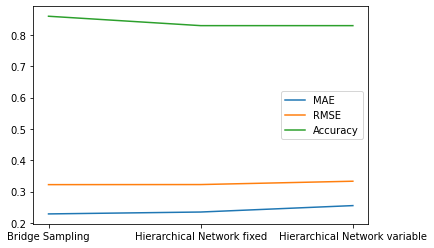

In [52]:
plt.plot(perf_metrics)
plt.legend(perf_metrics)

In [11]:
# Inspired by simulation-based calibration: 
# Does the proportion of selected models match the 50/50 prior 
# / the 49/51 proportion in the simulated datasets?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN fixed proportion = {}'.format(NN_fixed['selected_model'].mean()))
print('NN variable proportion = {}'.format(NN_variable['selected_model'].mean()))

# -> All methods exhibit a bias towards model 0, but the worst one (NN_variable) the least!

True proportion = 0.49
Bridge Sampling proportion = 0.39
NN fixed proportion = 0.36
NN variable proportion = 0.46


# Plot log BF approximation

In [53]:
def log_with_inf_replacement(x):
    """ Replaces Inf values with highest value possible and 
    then computes the log of the given array. 
    """
    
    x_copy = x.copy()
    if all(np.isfinite(x)) == False:
        x_copy[np.isfinite(x) == False] = sys.maxsize
    x_copy = np.log(x_copy)
    return x_copy

In [54]:
log_bridge_bfs = log_with_inf_replacement(bridge['bayes_factor'])
log_NN_fixed_bfs = log_with_inf_replacement(NN_fixed['bayes_factor'])
log_NN_variable_bfs = log_with_inf_replacement(NN_variable['bayes_factor'])

Text(0.5, 1.0, 'Bayes Factor approximation: Hierarchical Network trained with fixed dataset sizes')

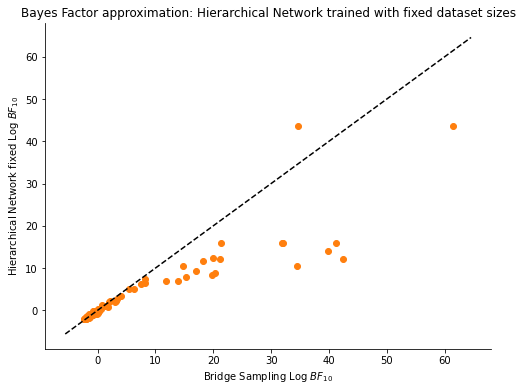

In [59]:
# vs fixed NN

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(log_bridge_bfs, log_NN_fixed_bfs, color = 'tab:orange')
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling Log $BF_{10}$')
ax.set_ylabel('Hierarchical Network fixed Log $BF_{10}$')
ax.set_title('Bayes Factor approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Bayes Factor approximation: Hierarchical Network trained with variable dataset sizes')

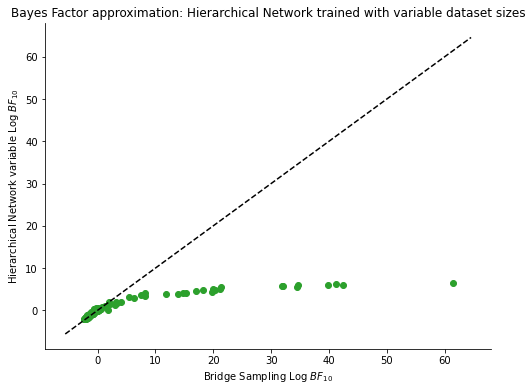

In [109]:
# vs variable NN

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(log_bridge_bfs, log_NN_variable_bfs, color = 'tab:green')
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling Log $BF_{10}$')
ax.set_ylabel('Hierarchical Network variable Log $BF_{10}$')
ax.set_title('Bayes Factor approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

# Plot Computation time as function of datasets

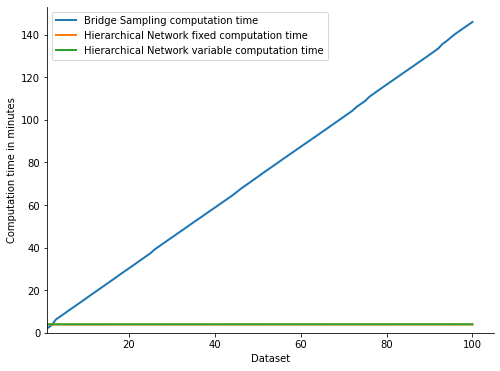

In [192]:
# Plot for all datasets

# Calculate computation times
bridge_time_min = (bridge['compile_time'] + (bridge['stan_time'] + bridge['bridge_time']).cumsum())/60
NN_fixed_time_min = (NN_fixed['training_time'] + NN_fixed['inference_time'].cumsum())/60
NN_variable_time_min = (NN_variable['training_time'] + NN_variable['inference_time'].cumsum())/60

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

# Plot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2)
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2)
ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Dataset')
ax.set_ylabel('Computation time in minutes')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.legend(loc='upper left')
f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')

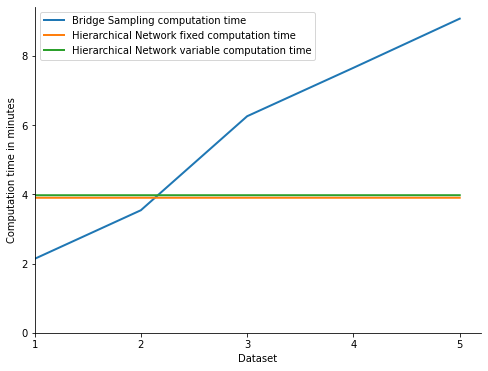

In [205]:
# Plot for subset

bridge_short = bridge.iloc[:5,:]
NN_fixed_short = NN_fixed.iloc[:5,:]
NN_variable_short = NN_variable.iloc[:5,:]

# Calculate computation times
bridge_time_min = ((bridge_short['compile_time'] + (bridge_short['stan_time'] + bridge_short['bridge_time']).cumsum())/60)
NN_fixed_time_min = ((NN_fixed_short['training_time'] + NN_fixed_short['inference_time'].cumsum())/60)
NN_variable_time_min = ((NN_variable_short['training_time'] + NN_variable_short['inference_time'].cumsum())/60)

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

# Plot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2)
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2)
ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Dataset')
ax.set_ylabel('Computation time in minutes')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.set_xticks(bridge_time_min.index) # only display ticks for each dataset
ax.legend(loc='upper left')
f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')